# 사전 훈련된 컨브넷 사용하기: VGG16

## 특성 추출

In [1]:
# VGG16 합성곱 기반 층 만들기

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(150,150,3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [3]:
# 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# 완전 연결 분류기에 주입하기 위해 (samples, 8192) 크기로 펼침

train_features = np.reshape(train_features, (2000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))


In [5]:
# 완전 연결 분류기를 정의하고 훈련하기

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))



Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5794 - acc: 0.6920 - val_loss: 0.4349 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.4157 - acc: 0.8120 - val_loss: 0.3510 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3386 - acc: 0.8575 - val_loss: 0.3161 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3038 - acc: 0.8780 - val_loss: 0.2938 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2687 - acc: 0.8950 - val_loss: 0.2776 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2524 - acc: 0.9050 - val_loss: 0.2675 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2408 - acc: 0.9035 - val_loss: 0.2612 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

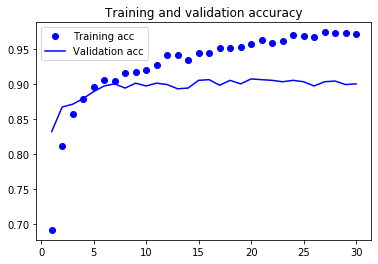

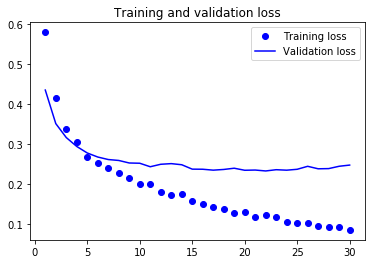

In [6]:
# 결과 그래프 그리기

import matplotlib.pyplot as plt 
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss ,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 데이터 증식을 사용한 특성 추출

In [7]:
# 합성곱 기반 층 위에 완전 연결 분류기 추가하기

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 합성곱 기반 층 동결하기

print('conv_base를 동결하기 전 훈련되는 가중치 수: ', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치 수:  30


In [10]:
conv_base.trainable = False

In [11]:
print('conv_base를 동결한 후 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수:  4


In [12]:
# 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
W0830 23:08:15.636657 139883257767680 deprecation.py:323] From <ipython-input-12-4b535d20fc6e>:43: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 - 29s - loss: 0.5839 - acc: 0.6955 - val_loss: 0.4383 - val_acc: 0.8250
Epoch 2/30
100/100 - 29s - loss: 0.4905 - acc: 0.7775 - val_loss: 0.3701 - val_acc: 0.8410
Epoch 3/30
100/100 - 27s - loss: 0.4371 - acc: 0.8045 - val_loss: 0.3311 - val_acc: 0.8640
Epoch 4/30
100/100 - 28s - loss: 0.4094 - acc: 0.8220 - val_loss: 0.3144 - val_acc: 0.8700
Epoch 5/30
100/100 - 27s - loss: 0.3837 - acc: 0.8180 - val_loss: 0.3064 - val_acc: 0.8690
Epoch 6/30
100/100 - 27s - loss: 0.3704 - acc: 0.8395 - val_loss: 0.2925 - val_acc: 0.8740
Epoch 7/30
100/100 - 27s - loss: 0.3664 - acc: 0.8365 - val_loss: 0.2725 

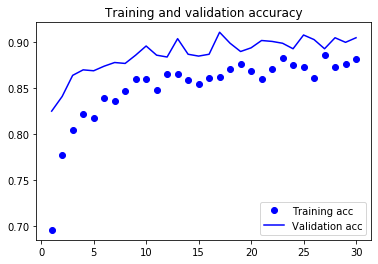

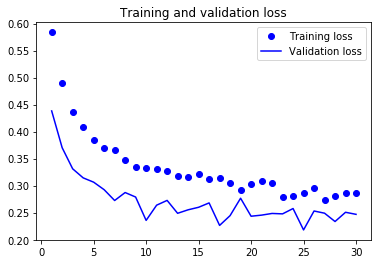

In [13]:
# 결과 그래프 그리기

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss ,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 미세 조정

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
# 특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
# 모델 미세 조정하기
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 29s 294ms/step - loss: 0.2947 - acc: 0.8635 - val_loss: 0.2191 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2675 - acc: 0.8880 - val_loss: 0.2058 - val_acc: 0.9240
Epoch 3/100
100/100 [==============================] - 29s 295ms/step - loss: 0.2369 - acc: 0.9035 - val_loss: 0.2586 - val_acc: 0.8930
Epoch 4/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2282 - acc: 0.9050 - val_loss: 0.2248 - val_acc: 0.9110
Epoch 5/100
100/100 [==============================] - 30s 296ms/step - loss: 0.2079 - acc: 0.9140 - val_loss: 0.1756 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 29s 294ms/step - loss: 0.2116 - acc: 0.9105 - val_loss: 0.2031 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 30s 296ms/step - loss: 0.1870 - acc: 0.9215 - val_loss: 0.1768 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

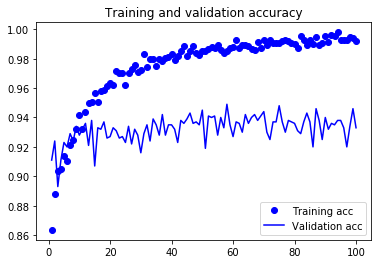

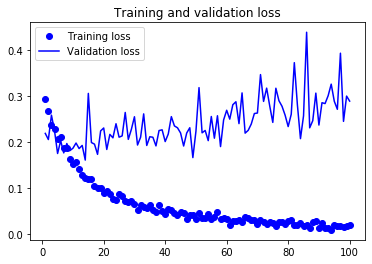

In [17]:
# 결과 그래프 그리기

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss ,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

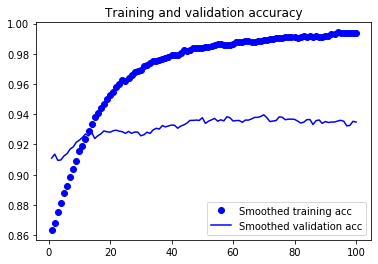

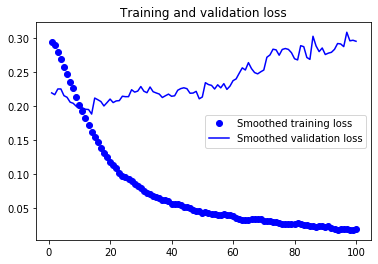

In [18]:
# 부드러운 그래프 그리기 (지수 이동 평균)

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

W0831 00:26:25.114415 139883257767680 deprecation.py:323] From <ipython-input-19-7ebfed7df528>:8: Model.evaluate_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.evaluate, which supports generators.
Found 1000 images belonging to 2 classes.
test acc:  0.9319999814033508
